In [25]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, HTML

from matplotlib.patches import FancyArrowPatch

In [26]:
current_dir = os.getcwd()
# Поднимаемся от текущей директории до spores/v14_back/src
project_root = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'src'))
if project_root not in sys.path:
    sys.path.append(project_root)

from logic.pendulum import PendulumSystem
from logic.control_tree import ControlTreeBuilder

# Настройка matplotlib для Jupyter
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['figure.dpi'] = 100

print("✅ Модули загружены")

✅ Модули загружены


In [27]:
def sort_grandchildren_simple(grandchildren, root_position):
    """
    Простая сортировка: фиксированное направление + roll по условию.
    """
    
    def get_angle_from_root(gc):
        dx = gc['position'][0] - root_position[0]
        dy = gc['position'][1] - root_position[1] 
        return np.arctan2(dy, dx)
    
    # 1. Сортируем по углу (против часовой стрелки)
    sorted_gc = sorted(grandchildren, key=get_angle_from_root, reverse=True)
    
    # 2. Находим внука от родителя 0
    roll_offset = 0
    for i, gc in enumerate(sorted_gc):
        if gc['parent_idx'] == 0:
            roll_offset = i
            break
    
    # 3. Делаем roll чтобы внук родителя 0 стал первым
    sorted_gc = np.roll(sorted_gc, -roll_offset).tolist()
    
    # 4. Проверяем критерий: 1-й внук от другого родителя?
    if len(sorted_gc) >= 2 and sorted_gc[1]['parent_idx'] == 0:
        # Если 1-й тоже от родителя 0, сдвигаем на 1
        sorted_gc = np.roll(sorted_gc, 1).tolist()
        print("🔄 Применен дополнительный roll +1")
    
    print(f"✅ Обход: 0-й от родителя {sorted_gc[0]['parent_idx']}, 1-й от родителя {sorted_gc[1]['parent_idx']}")
    return sorted_gc

In [28]:
def build_simple_tree(initial_position, dt_value, pendulum, show: bool = False):
    """
    Строит простое дерево спор глубиной 1.
    
    Args:
        initial_position: np.array([theta, theta_dot]) - начальная позиция
        dt_value: float - временной шаг
    
    Returns:
        dict с корневой спорой и 4 потомками
    """
    if show:
        print(f"🌱 Строим дерево из позиции {initial_position} с dt={dt_value}")
    
    # Получаем границы управления
    u_min, u_max = pendulum.get_control_bounds()
    
    # Корневая спора
    root = {
        'position': initial_position.copy(),
        'id': 'root',
        'color': 'red',
        'size': 100
    }
    
    # 4 потомка с разными комбинациями control и dt
    children = []
    configs = [
        {'control': u_max, 'dt': dt_value, 'name': 'forward_max', 'color': 'blue'},
        {'control': u_max, 'dt': -dt_value, 'name': 'backward_max', 'color': 'cyan'}, 
        {'control': u_min, 'dt': dt_value, 'name': 'forward_min', 'color': 'green'},
        {'control': u_min, 'dt': -dt_value, 'name': 'backward_min', 'color': 'orange'}
    ]
    
    for i, config in enumerate(configs):
        # Вычисляем новую позицию
        new_pos = pendulum.scipy_rk45_step(initial_position, config['control'], config['dt'])
            
        child = {
            'position': new_pos,
            'id': f"child_{i}",
            'name': config['name'],
            'color': config['color'],
            'size': 60,
            'control': config['control'],
            'dt': config['dt']
        }
        children.append(child)
        
        if show:
            print(f"  🍄 {config['name']}: u={config['control']:+.1f}, dt={config['dt']:+.3f} → {new_pos}")
    
    # Сортируем детей по углу относительно корня для правильного порядка обхода
    def get_angle(child):
        dx = child['position'][0] - root['position'][0] 
        dy = child['position'][1] - root['position'][1]
        return np.arctan2(dy, dx)
    
    children_sorted = sorted(children, key=get_angle)
    
    # Переназначаем ID по порядку
    for i, child in enumerate(children_sorted):
        child['id'] = f"child_{i}"
    
    if show:
        print("\n🔄 После сортировки по углу:")
        for i, child in enumerate(children_sorted):
            angle = get_angle(child) * 180 / np.pi  # В градусах для читаемости
            print(f"  {i}: {child['name']} под углом {angle:.1f}°")

    grandchildren = []
    print("\n🌳 Строим уровень 2 (dt уменьшено в 10 раз):")

    k = 2
    gc_dt = dt_value / k  # Уменьшаем dt в 10 раз для внуков

    for parent_idx, parent in enumerate(children_sorted):
        # Обращаем знак управления родителя
        reversed_control = -parent['control']
        
        print(f"\n  👶 От споры {parent_idx} (u={parent['control']:+.1f}) строим детей с u={reversed_control:+.1f}, dt={gc_dt:.4f}:")
        
        # 2 потомка с обращенным управлением: +dt и -dt
        grandchild_configs = [
            {'dt': gc_dt, 'name': f'gc_{parent_idx}_forward', 'color': 'lightblue'},
            {'dt': -gc_dt, 'name': f'gc_{parent_idx}_backward', 'color': 'lightcoral'}
        ]
        
        for gc_idx, gc_config in enumerate(grandchild_configs):
            new_pos = pendulum.scipy_rk45_step(parent['position'], reversed_control, gc_config['dt'] / k)
            
            grandchild = {
                'position': new_pos,
                'parent_id': parent['id'],
                'parent_idx': parent_idx,
                'local_idx': gc_idx,  # Индекс внутри родителя (0 или 1)
                'id': f"gc_{parent_idx}_{gc_idx}",
                'name': gc_config['name'],
                'color': gc_config['color'],
                'size': 40,
                'control': reversed_control,
                'dt': gc_config['dt']
            }
            grandchildren.append(grandchild)
            
            if show:
                direction = "вперед" if gc_config['dt'] > 0 else "назад"
                print(f"    🌱 {gc_idx}: u={reversed_control:+.1f}, dt={gc_config['dt']:+.3f} ({direction}) → {new_pos}")

    grandchildren_sorted = sort_grandchildren_simple(grandchildren, root['position'])
    
    # Переназначаем глобальные индексы
    for i, gc in enumerate(grandchildren_sorted):
        gc['global_idx'] = i
    
    print("\n🔄 Итоговый порядок внуков:")
    for i, gc in enumerate(grandchildren_sorted):
        print(f"  {i}: родитель {gc['parent_idx']}, u={gc['control']:+.1f}, dt={gc['dt']:+.4f}")
        
    return {
        'root': root,
        'children': children_sorted,
        'grandchildren': grandchildren  # Добавляем внуков
    }
    
# ========== ИСПОЛЬЗОВАНИЕ ==========

# Начальная позиция: небольшой угол и нулевая скорость


In [33]:


def visualize_tree(tree_data):
    """
    Визуализирует дерево спор с траекториями и стрелочками.
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    root = tree_data['root']
    children = tree_data['children']
    
    # Рисуем корневую спору
    ax.scatter(root['position'][0], root['position'][1], 
              c=root['color'], s=root['size'], alpha=0.8, 
              label='Root', edgecolors='black', linewidth=2)
    
    # Рисуем детей и стрелочки от корня к детям
    for i, child in enumerate(children):

        # Номер рядом с точкой
        percent = 0.0001
        ax.text(child['position'][0] * (1 + percent), child['position'][1] * (1 + percent), 
            str(i), fontsize=12, fontweight='bold', 
            color='black', ha='left', va='bottom',
            bbox=dict(boxstyle="circle,pad=0.1", facecolor='white', alpha=0.8))
        # Точка-потомок
        ax.scatter(child['position'][0], child['position'][1],
                  c=child['color'], s=child['size'], alpha=0.7,
                  label=child['name'], edgecolors='black')
        
        # Стрелочка от корня к потомку
        arrow = FancyArrowPatch(
            (root['position'][0], root['position'][1]),
            (child['position'][0], child['position'][1]),
            arrowstyle='->', 
            mutation_scale=15,
            color=child['color'],
            alpha=0.6,
            linewidth=2
        )
        ax.add_patch(arrow)
        
        # Аннотация с параметрами
        mid_x = (root['position'][0] + child['position'][0]) / 2
        mid_y = (root['position'][1] + child['position'][1]) / 2
        
        label_text = f"u={child['control']:+.1f}\ndt={child['dt']:+.3f}"
        ax.annotate(label_text, (mid_x, mid_y), 
                   fontsize=8, ha='center', va='center',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7))
    
    # Настройки графика
    ax.set_xlabel('θ (радианы)', fontsize=12)
    ax.set_ylabel('θ̇ (рад/с)', fontsize=12) 
    ax.set_title(f'Дерево спор глубиной 1 (dt = {dt})', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Равные пропорции осей
    # ax.set_aspect('equal', adjustable='box')

    if 'grandchildren' in tree_data:
        for grandchild in tree_data['grandchildren']:
            # Точка-внук
            ax.scatter(grandchild['position'][0], grandchild['position'][1],
                    c=grandchild['color'], s=grandchild['size'], alpha=0.6,
                    edgecolors='gray', linewidth=1)
            
            # Стрелочка от родителя к внуку
            parent = children[grandchild['parent_idx']]
            arrow = FancyArrowPatch(
                (parent['position'][0], parent['position'][1]),
                (grandchild['position'][0], grandchild['position'][1]),
                arrowstyle='->', 
                mutation_scale=10,
                color=grandchild['color'],
                alpha=0.5,
                linewidth=1.5
            )
            ax.add_patch(arrow)
            
            percent_1 = 0.1
            percent_2 = 0.05
            # Номер внука
            ax.text(grandchild['position'][0] - (root['position'][0] - grandchild['position'][0]) * percent_1 * ((grandchild['parent_idx'] % 2 == 1) * 2 - 1), 
                    grandchild['position'][1] - (root['position'][1] - grandchild['position'][1]) * percent_2 * ((grandchild['parent_idx'] % 2 == 1) * 2 - 1), 
                f"{grandchild['parent_idx']}.{grandchild['id'].split('_')[-1]}", 
                fontsize=8, fontweight='bold', 
                color='white', ha='center', va='center',
                bbox=dict(boxstyle="circle,pad=0.1", facecolor='gray', alpha=0.7))
            

            label = str(grandchild.get('global_idx', '?'))  # Показываем ? если индекса нет
            ax.text(grandchild['position'][0], grandchild['position'][1], 
                   label, fontsize=10, fontweight='bold', 
                   color='white', ha='center', va='center',
                   bbox=dict(boxstyle="circle,pad=0.15", facecolor='purple', alpha=0.8))
    
    
    plt.tight_layout()
    plt.show()



🌳 Строим уровень 2 (dt уменьшено в 10 раз):

  👶 От споры 0 (u=-2.0) строим детей с u=+2.0, dt=0.0500:

  👶 От споры 1 (u=+2.0) строим детей с u=-2.0, dt=0.0500:

  👶 От споры 2 (u=+2.0) строим детей с u=-2.0, dt=0.0500:

  👶 От споры 3 (u=-2.0) строим детей с u=+2.0, dt=0.0500:
🔄 Применен дополнительный roll +1
✅ Обход: 0-й от родителя 1, 1-й от родителя 0

🔄 Итоговый порядок внуков:
  0: родитель 1, u=-2.0, dt=+0.0500
  1: родитель 0, u=+2.0, dt=-0.0500
  2: родитель 0, u=+2.0, dt=+0.0500
  3: родитель 3, u=+2.0, dt=-0.0500
  4: родитель 3, u=+2.0, dt=+0.0500
  5: родитель 2, u=-2.0, dt=-0.0500
  6: родитель 2, u=-2.0, dt=+0.0500
  7: родитель 1, u=-2.0, dt=-0.0500


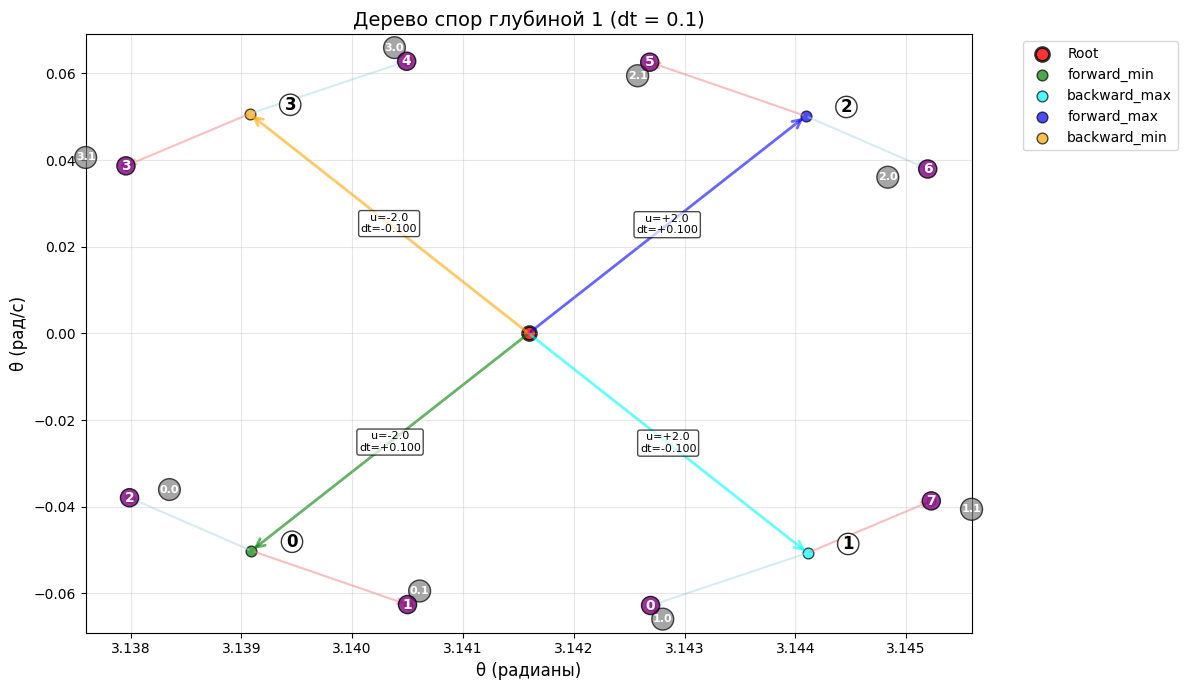

In [34]:

dt = 0.1  # Временной шаг - можно менять!

# Создаем систему маятника (используем из проекта)
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

initial_pos = np.array([np.pi, 0.0])

# Строим дерево
tree = build_simple_tree(initial_pos, dt, pendulum)

# Визуализируем  
visualize_tree(tree)

# print(f"\n📊 Статистика:")
# print(f"Корневая спора: {tree['root']['position']}")
# print(f"Количество потомков: {len(tree['children'])}")
# for child in tree['children']:
#     distance = np.linalg.norm(child['position'] - tree['root']['position'])
#     print(f"  {child['name']}: расстояние от корня = {distance:.3f}")